In [1]:
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display
import soundfile as sf
import matplotlib.patches as patch
import matplotlib.pyplot as plt
import IPython.display as ipd
from pathlib import Path
from tqdm.notebook import tqdm
from scipy.io import wavfile
import time
import os
import shutil
from skimage import io
from skimage.color import rgb2gray,rgba2rgb
#https://github.com/iver56/audiomentations ?
%matplotlib inline
CC_ROOT=Path("D:\\KidElectric\\rfcx_kaggle") #Cookiecutter datascience-style project
CC_DATA_OUT=CC_ROOT.joinpath('data').joinpath('interim')

DATA_ROOT = CC_ROOT.joinpath('data')
TRAIN_AUDIO_ROOT = DATA_ROOT.joinpath('raw').joinpath('train')#Update to point to cookiecutter data/raw/train
TEST_AUDIO_ROOT = DATA_ROOT.joinpath('raw').joinpath('test')#Update to point to cookiecutter data/raw/test


df_train = pd.DataFrame({
    "recording_id": [path.stem for path in TRAIN_AUDIO_ROOT.glob("*.flac")],
})

df_test = pd.DataFrame({
    "recording_id": [path.stem for path in TEST_AUDIO_ROOT.glob("*.flac")],
})

df_tp=pd.read_csv(CC_ROOT.joinpath('references').joinpath('train_tp.csv')).set_index('recording_id')

df_fp=pd.read_csv(CC_ROOT.joinpath('references').joinpath('train_fp.csv')).set_index('recording_id')


In [16]:
class params:
    """
    Parameters used for generating spectrograms from audio data
    """
    sr = 48000 #sampling rate

    # Melspectrogram
    n_mels = 128
    fmin = 80
    fmax = 14000  
    n_fft=2048
    hop_length = 512
    
def load_audio(pnfn="", sr=48000):
    y, _ = lb.load(pnfn,
        sr=sr, 
    )
    return y

def compute_melspec(y, params):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = lb.feature.melspectrogram(
        y, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax, hop_length=params.hop_length,n_fft=params.n_fft
    )
    melspec = lb.power_to_db(melspec).astype(np.float32)
    return melspec

def foreground_background_trfm(y):
    """ Computes foreground / background spectral separation
        Arguments:
        y {np array} -- signal
        
    """
    S_full, phase = lb.magphase(librosa.stft(y))
    
    # Try librosa segmentation example:
    S_filter = lb.decompose.nn_filter(S_full,
                                           aggregate=np.median,
                                           metric='cosine',
                                           width=int(lb.time_to_frames(2, sr=params.sr)))

    # The output of the filter shouldn't be greater than the input
    # if we assume signals are additive.  Taking the pointwise minimium
    # with the input spectrum forces this.
    S_filter = np.minimum(S_full, S_filter)    
    margin_i, margin_v = 2, 10
    power = 2
    mask_i = librosa.util.softmask(S_filter,
                                   margin_i * (S_full - S_filter),
                                   power=power)

    mask_v = librosa.util.softmask(S_full - S_filter,
                                   margin_v * S_filter,
                                   power=power)

    # Once we have the masks, simply multiply them with the input spectrum
    # to separate the components

    S_foreground = mask_v * S_full
    S_background = mask_i * S_full
    return S_full, S_foreground, S_background

def make_box(df_tp,recording):
    t_start=df_tp['t_min'][recording]
    t_stop= df_tp['t_max'][recording]
    f_min= df_tp['f_min'][recording]
    f_max= df_tp['f_max'][recording]
    #matplotlib.patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
    width=t_stop-t_start
    height=f_max-f_min
    xy=(t_start,f_min)
    return t_start, t_stop, f_min, f_max

def has_tp_fp(rec,df_tp,df_fp):
    #Many recordings have both tp and fp data labeled.
    has_tp=False
    has_fp=False
    if rec in df_tp.index:
        has_tp = True
    if rec in df_fp.index:
        has_fp = True
    return has_tp, has_fp

def clip_info(rec,df):
    keep={'species_id':[],'t_min':[],'t_max':[]}
    for key in df.keys():
        if key in keep.keys():
            if isinstance(df[key][rec],pd.core.series.Series):
                keep[key]=[val for val in df[key][rec].values]
            else:
                keep[key].append(df[key][rec])
    return keep

def clip_identity(rec,df_tp,df_fp,start,stop):
    out={'tp_spec':[],'tp':0,
         'fp_spec':[],'fp':0}
    has_fp=False
    has_tp=False
    if rec in df_tp.index:
        info = clip_info(rec,df_tp)
        for i,spec in enumerate(info['species_id']):
            t_min=info['t_min'][i]
            t_max=info['t_max'][i]
            overlap=(t_min < stop and t_min >= start) or (t_max >= start and t_max < stop)
            if overlap == True:
                has_tp=True
                out['tp_spec'].append(spec)
                out['tp']+=1
    
    if rec in df_fp.index:
        info = clip_info(rec,df_fp)
        for i,spec in enumerate(info['species_id']):
            t_min=info['t_min'][i]
            t_max=info['t_max'][i]
            overlap=(t_min < stop and t_min >= start) or (t_max >= start and t_max < stop)
            if overlap == True:
                has_fp=True
                out['fp_spec'].append(spec + 24)
                out['fp']+=1   
    return out

def subtract_median(med,melspec):
    med_sub=np.zeros(melspec.shape)
    for i,col in enumerate(melspec.transpose()):
        med_sub[:,i]=col-med 
    return med_sub

def plot_and_save(dat,params):
        idx=params.idx
        params.ax=[]
        for i in range(0,3,1):
            ax=plt.subplot(3,1,i+1)
            params.ax.append(ax)
            ax.axis('off') 
            ax.xaxis.set_major_locator(plt.NullLocator())
            ax.yaxis.set_major_locator(plt.NullLocator())
        plt.subplots_adjust(wspace=0, hspace=0)
        for i,d in enumerate(dat):
            lb.display.specshow(lb.amplitude_to_db(d[:, idx], ref=np.max),
                                y_axis='log', sr=params.sr, ax=params.ax[i])

        img_pnfn=params.img_pnfn
        print('\tSaving to %s' % img_pnfn)
        plt.savefig(img_pnfn, pad_inches=0, bbox_inches='tight', transparent=True)
        time.sleep(0.1)
        plt.clf()
        
def save_spectrum_image(y,params,df_tp,df_fp):
    fs=params.sr
    use_root=params.use_root
    print('\t Separating foreground from background...')
    full,fore,back = foreground_background_trfm(y)
    dat=[full,fore,back]
    print('\t Separated! Plotting...')
    # Make spectrogram clips:
    for c,i in enumerate(range(0,params.rec_length,params.clip_dur)):
        start=i
        stop=i+params.clip_dur
        params.idx = slice(*lb.time_to_frames([start,stop], sr=params.sr))
        save_clip=False
        if params.mode == 'TRAIN':            
            clip_id=clip_identity(params.fn,df_tp,df_fp,start,stop)
            if clip_id['tp'] == 1:
                #If clip has one true positive, label that species:
                img_fn='TP_%s_%s_%d.png' % (clip_id['tp_spec'][0],params.fn,c)
                save_clip = True
            if clip_id['tp'] == 0 and clip_id['fp']>=1:
                #If clip has no true positives and at least 1 false positive, label as first false positive species:
                img_fn='FP_%s_%s_%d.png' % (clip_id['fp_spec'][0],params.fn,c)
                save_clip = True
            if clip_id['tp'] == 0 and clip_id['fp']==0:
                #If clip has no TP or FP, label as a unique species id 99:
                img_fn='NP_%s_%s_%d.png' % ('99',params.fn,c)
                save_clip = False # Exclude empty clips for now...
        elif params.mode == 'TEST':
            img_fn='%s_%d' % (params.fn,c)
            save_clip=True
       
        if save_clip == True: 
            params.img_pnfn=params.dest.joinpath(img_fn)
            plot_and_save(dat,params)




In [ ]:
# Make spectrum for each species in recording in train/test:
fig=plt.figure(figsize=(12, 8))


modes = ['TRAIN','TEST']
params.clip_dur=6 # second chunks
params.tp_limit=1 # 1TP max per clip

for mode in modes:
    if mode == 'TEST':
        resume=0
        use_df=df_test
        use_root=TEST_AUDIO_ROOT 
        params.dest=DATA_ROOT.joinpath('interim').joinpath('test').joinpath('clip_decomp')
    elif mode == 'TRAIN':
        resume=1194
        use_df=df_train
        use_root=TRAIN_AUDIO_ROOT
        params.dest=DATA_ROOT.joinpath('interim').joinpath('train').joinpath('clip_decomp')
    params.use_root=use_root
       
    if params.dest.exists() == False:
        os.mkdir(params.dest)
    for ii,fn in enumerate(use_df['recording_id'][resume:]):
        pnfn=use_root.joinpath(fn).with_suffix(".flac")
        _,fs=sf.read(pnfn)
        params.sr=fs
        params.mode=mode

        print('\n%d of %d. Loading...' % (resume+ii, len(use_df['recording_id'])))        
        params.fn=fn
        y = load_audio(pnfn, params.sr)
        print('\tLoaded.')
        params.rec_length=int(y.shape[0]/params.sr)
        save_spectrum_image(y,params,df_tp,df_fp)


1194 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_2_41829d963_1.png

1195 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_13_419259ac2_9.png

1196 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_419abdc78_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_419abdc78_7.png

1197 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_419fb1a93_3.png

1198 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_42a7c4f08_6.png

1221 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_42b240c98_8.png

1222 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_42b51edce_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_42b51edce_5.png

1223 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_42cfdbd16_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_42cfdbd16_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_42cfdbd16_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_438c12dbc_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_438c12dbc_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_438c12dbc_8.png

1246 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_18_43b27b5ab_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_18_43b27b5ab_4.png

1247 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_43b921322_4.png

1248 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_43befeb3e_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_457fdb9b8_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_457fdb9b8_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_457fdb9b8_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_457fdb9b8_7.png

1271 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_458ae77db_9.png

1272 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_458e5dff4_1.png

1273 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_459389f95_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_471169d06_8.png

1300 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_12_471bb3a84_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_12_471bb3a84_5.png

1301 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_11_471df4911_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_11_471df4911_8.png

1302 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_11_473cac467_1.png

1303 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data


1325 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_22_48a77f450_8.png

1326 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_1_48b7f6cde_2.png

1327 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_48c67fb9c_0.png

1328 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_48cdb654a_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_48cdb654a_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_45_48cdb654a_6.png

1329 of 4727. Loading...
	Loaded.
	 Separa

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_49b80ec61_7.png

1351 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_49c8a7689_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_49c8a7689_9.png

1352 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_49cde9c89_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_49cde9c89_2.png

1353 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_49dd06c3b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_49dd06c3b_7.png

1354 of 4727. Loading...
	Loaded.
	 Separating foregr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_0_4b3e0b984_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_4b3e0b984_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_4b3e0b984_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_4b3e0b984_7.png

1376 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_4_4b406a1bc_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_4_4b406a1bc_2.png

1377 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_4b4101adf_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_4b4101adf_9.png

1378 of 4727. Loading...
	Loaded.
	 Separating foreground from backg

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_12_4c845907b_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_45_4c845907b_9.png

1402 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_4c8d4eda8_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_4c8d4eda8_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_4c8d4eda8_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_4c8d4eda8_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_4c8d4eda8_7.png

1403 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_4c9651227_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco


1427 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_4ddebf17c_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_4ddebf17c_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_4ddebf17c_8.png

1428 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_4de8a9cc1_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_4de8a9cc1_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_4de8a9cc1_9.png

1429 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_17_4df50c66e_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_4efa1757c_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_4efa1757c_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_4efa1757c_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_4efa1757c_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_4efa1757c_6.png

1455 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_4f0921393_7.png

1456 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_4f1e24bce_8.png

1457 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra


1485 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_50837f004_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_50837f004_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_50837f004_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_50837f004_9.png

1486 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_50858c287_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_50858c287_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_50858c287_7.png

1487 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra


1509 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_51cb253b0_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_51cb253b0_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_7_51cb253b0_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_7_51cb253b0_8.png

1510 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_51cb31962_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_51cb31962_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_51cb31962_8.png

1511 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_33_53517f2da_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_53517f2da_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_53517f2da_2.png

1535 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_53584aeac_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_53584aeac_6.png

1536 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_5358a0dcc_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_5358a0dcc_8.png

1537 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfc


1557 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_5479942ee_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_5479942ee_5.png

1558 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_22_5493f3b1a_2.png

1559 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_549dc3831_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_549dc3831_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_549dc3831_9.png

1560 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_55b2b19d1_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_55b2b19d1_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_23_55b2b19d1_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_23_55b2b19d1_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_23_55b2b19d1_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_23_55b2b19d1_9.png

1582 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_55b5a85fb_9.png

1583 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_55d68ab36_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco


1606 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_56ea06d62_3.png

1607 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_56fd2d188_3.png

1608 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_1_56ff074df_0.png

1609 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_12_5723a520c_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_12_5723a520c_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_5723a520c_7.png

1610 of 4727. Loading...
	Loaded.
	 Separa


1633 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_1_5857d6f6d_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_1_5857d6f6d_3.png

1634 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_5860d1a7c_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_5860d1a7c_3.png

1635 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_58679c300_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_58679c300_4.png

1636 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\i

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_596f1e93a_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_596f1e93a_7.png

1659 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_1_5977f6b4c_2.png

1660 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_599b19a33_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_599b19a33_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_599b19a33_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_599b19a33_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_15_599b19a33_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_5a7559415_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_5a7559415_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_5a7559415_7.png

1685 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_17_5a7cc4e44_8.png

1686 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_18_5a8a2b155_5.png

1687 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_5ab5becc0_6.png

1688 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\Kid


1707 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_5b6a0c5b2_3.png

1708 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_5b7edd6c7_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_5b7edd6c7_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_5b7edd6c7_6.png

1709 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_8_5b8830884_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_8_5b8830884_6.png

1710 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\i

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_5cbd74b02_9.png

1734 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_5cd0bc1bf_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_5cd0bc1bf_6.png

1735 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_5cd1a3c29_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_5cd1a3c29_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_5cd1a3c29_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_12_5cd1a3c29_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_5cd1a3c29_8.png

1736 of 4727. Loading...
	Loaded.
	 Sepa

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_5df72003d_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_5df72003d_7.png

1759 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_5e305a689_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_5e305a689_3.png

1760 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_5e4f49aad_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_5e4f49aad_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_5e4f49aad_6.png

1761 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfc

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_5f51598f1_9.png

1782 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_5f6ecdc4f_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_33_5f6ecdc4f_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_5f6ecdc4f_9.png

1783 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_5f8eecc9e_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_23_5f8eecc9e_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_23_5f8eecc9e_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_5f8eecc9e_7.png

1784 of 4727. Loading...
	Loaded.
	 Separating foreground from ba


1808 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_60f6111b2_0.png

1809 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_60fc31567_7.png

1810 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_3_6102fb9d6_2.png

1811 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_61215a02d_0.png

1812 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_33_6166bd53b_5.png
	Saving to D:\KidElectric\rfcx_


1834 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_62789b07d_4.png

1835 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_12_629489592_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_629489592_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_629489592_5.png

1836 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_62ad21b63_7.png

1837 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_62bb0ffa5_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_13_63cc4d598_6.png

1863 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_63e47e918_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_63e47e918_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_63e47e918_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_63e47e918_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_63e47e918_8.png

1864 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_63fbf2f2e_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_63fbf2f2e_5.png
	Saving to D:\KidElectric\rfcx_kaggle\dat

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_6553d31ad_9.png

1889 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_17_655ca0adb_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_17_655ca0adb_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_655ca0adb_9.png

1890 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_656a61cad_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_656a61cad_2.png

1891 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_65727379c_5.png

1892 of 4727. Loading...
	Loaded.
	 Separating foregr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_66c798e69_9.png

1913 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_66c81cfbe_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_66c81cfbe_5.png

1914 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_66d9dd900_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_66d9dd900_8.png

1915 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_66ef262ad_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_66ef262ad_8.png

1916 of 4727. Loading...
	Loaded.
	 Separating foregr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_687733bf1_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_687733bf1_6.png

1942 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_687d7c1a1_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_687d7c1a1_4.png

1943 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_688975ce0_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_45_688975ce0_8.png

1944 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_13_689b160fc_4.png

1945 of 4727. Loading...
	Loaded.
	 Separating foregr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_6a317163a_8.png

1970 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_6a52e9f6f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_45_6a52e9f6f_6.png

1971 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_6a5511f58_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_6a5511f58_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_6a5511f58_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_6a5511f58_6.png

1972 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_6b891f8f2_4.png

1995 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_6b8cf6e79_0.png

1996 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_21_6b9e3f7c6_1.png

1997 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_6bb8d1ca4_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_6bb8d1ca4_9.png

1998 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_6bc20e7cd_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_45_6cda2ee54_9.png

2023 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_6d0148a8c_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_6d0148a8c_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_6d0148a8c_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_6d0148a8c_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_6d0148a8c_9.png

2024 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_6d108a590_8.png

2025 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_6e9a6ed8e_9.png

2052 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_6e9ed6a4c_9.png

2053 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_6eb03e9ca_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_7_6eb03e9ca_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_7_6eb03e9ca_2.png

2054 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_6eba8c879_0.png

2055 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\i


2079 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_70e7af8ab_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_70e7af8ab_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_70e7af8ab_8.png

2080 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_710177a21_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_710177a21_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_710177a21_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_710177a21_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_710177a21_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_7_7227068d3_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_7227068d3_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_7227068d3_9.png

2106 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_8_725c5b6f1_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_8_725c5b6f1_9.png

2107 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_17_7277aa5a8_9.png

2108 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_10_728459067_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\


2134 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_73c482b64_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_73c482b64_4.png

2135 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_17_73c4d8db8_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_17_73c4d8db8_9.png

2136 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_73c6702b4_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_73c6702b4_2.png

2137 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_7509ed370_2.png

2163 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_4_750e35881_8.png

2164 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_751355a27_9.png

2165 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_751e3bab9_0.png

2166 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_751ecb98f_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_751ecb98f_8.png

2167 of 4727. Loading...
	Loaded.
	 Separa

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_7693a6573_8.png

2193 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_769830f8a_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_769830f8a_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_769830f8a_9.png

2194 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_9_76b4b3f7f_9.png

2195 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_21_76bcc78f1_0.png

2196 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_78206c183_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_78206c183_5.png

2224 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_7821ee6cf_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_7821ee6cf_4.png

2225 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_7824bd6ff_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_7824bd6ff_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_7824bd6ff_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_7824bd6ff_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco


2248 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_7_78f515b6f_5.png

2249 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_79079cc0e_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_79079cc0e_7.png

2250 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_4_7925510fe_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_4_7925510fe_6.png

2251 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_45_792d5e933_7.png

2252 of 4727. Loading...
	Loaded.
	 Separati

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_7a9440afc_1.png

2276 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_22_7a9d46229_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_5_7a9d46229_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_5_7a9d46229_9.png

2277 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_7aa9e515a_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_7aa9e515a_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_7aa9e515a_9.png

2278 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_7b975d9f0_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_7b975d9f0_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_7b975d9f0_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_7b975d9f0_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_7b975d9f0_9.png

2302 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_7bab1669f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_7bab1669f_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_7bab1669f_9.png

2303 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_7d8f64e05_6.png

2330 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_7d96e43c0_0.png

2331 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_7de7d4ab5_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_7de7d4ab5_3.png

2332 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_7dea23e90_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_7dea23e90_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_7dea23e90_7.png

2333 of 4727. Loading...
	Loaded.
	 Separating foregr


2361 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_13_7f737a9c4_7.png

2362 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_4_7f8fab554_2.png

2363 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_4_7f9246130_0.png

2364 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_1_7f9b94a29_1.png

2365 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_7fa24d225_1.png
	Saving to D:\KidElectric\rfcx_ka

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_806efa0f6_4.png

2388 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_8079bbc3f_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_8079bbc3f_6.png

2389 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_807efd6bb_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_807efd6bb_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_807efd6bb_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_807efd6bb_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_3_807efd6bb_8.png

2390 of 4727. Loading...
	Loaded.
	 Separating foreground from bac

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_8250cac8d_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_33_8250cac8d_4.png

2419 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_11_8253e1640_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_11_8253e1640_7.png

2420 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_826093ce7_2.png

2421 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_8266ff1ed_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_8266ff1ed_2.png

2422 of 4727. Loading...
	Lo

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_83e7aeffd_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_83e7aeffd_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_83e7aeffd_9.png

2448 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_83ef06c68_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_83ef06c68_7.png

2449 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_83fc504e9_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_83fc504e9_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_83fc504e9_7.png
	Saving to D:\KidElectric\rfcx_kaggle\dat


2470 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_8531f27ff_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_8531f27ff_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_8531f27ff_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_7_8531f27ff_9.png

2471 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_853893fc2_6.png

2472 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_853ff55d3_4.png

2473 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_86b8099d1_1.png

2495 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_0_86c44dd51_5.png

2496 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_86c4cbd43_6.png

2497 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_86ce9a9b9_0.png

2498 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_86de74a7c_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_86de74a7c_1.png

2499 of 4727. Loading...
	Loaded.
	 Separa


2521 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_883db48e7_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_883db48e7_7.png

2522 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_883e9f18a_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_883e9f18a_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_883e9f18a_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_883e9f18a_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_883e9f18a_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_883e9f18a_8.png

2523 of 4727. Loading...
	Loaded.
	 Separating foreground from ba


2550 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_89a581634_2.png

2551 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_89a8436e2_4.png

2552 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_89c1d65c3_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_89c1d65c3_2.png

2553 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_89c42b347_4.png

2554 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx


2583 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_8b99ccd88_1.png

2584 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_8bc0657db_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_8bc0657db_4.png

2585 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_8bdb3be80_8.png

2586 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_8bf114c9c_3.png

2587 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx


2608 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_8d1192f16_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_8d1192f16_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_8d1192f16_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_8d1192f16_6.png

2609 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_33_8d1aa8b4f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_8d1aa8b4f_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_8d1aa8b4f_2.png

2610 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra


2634 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_10_8eb0e591c_7.png

2635 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_8eb1bc5e1_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_8eb1bc5e1_9.png

2636 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_8ebdbcf48_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_8ebdbcf48_9.png

2637 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_45_8ec106891_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data


2662 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_90170bbf9_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_90170bbf9_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_90170bbf9_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_90170bbf9_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_90170bbf9_8.png

2663 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_90387f1bd_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_90387f1bd_9.png

2664 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_45_914837e59_6.png

2685 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_915443145_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_915443145_3.png

2686 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_91554a8fb_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_91554a8fb_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_91554a8fb_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_91554a8fb_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_91554a8fb_5.png

2687 of 4727. Loading...
	Loaded.
	 Separating foreground from ba

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_92940cac2_9.png

2712 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_929d655d3_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_929d655d3_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_3_929d655d3_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_929d655d3_9.png

2713 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_10_92ae9bcc2_4.png

2714 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_92bad93c6_5.png

2715 of 4727. Loading...
	Loaded.
	 Separating foregro


2740 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_9425c4b01_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_9425c4b01_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_12_9425c4b01_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_12_9425c4b01_9.png

2741 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_942b41be5_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_942b41be5_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_942b41be5_9.png

2742 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_9568317d4_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_9568317d4_7.png

2769 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_23_956aaf47c_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_23_956aaf47c_4.png

2770 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_957141585_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_957141585_6.png

2771 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_9572bfa64_5.png

2772 of 4727. Loading...
	Loaded.
	 Separating foregr


2796 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_97614a6b0_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_97614a6b0_9.png

2797 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_0_97630c03d_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_0_97630c03d_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_97630c03d_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_97630c03d_4.png

2798 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_33_9769745d4_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_98bd045dc_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_98bd045dc_2.png

2825 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_98cb8fb08_2.png

2826 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_98d039965_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_98d039965_9.png

2827 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_98d2722f5_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_98d2722f5_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_9a18a1177_2.png

2849 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_9a33fd3e2_1.png

2850 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_9a390abd3_4.png

2851 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_9a4ecc73d_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_9a4ecc73d_1.png

2852 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_9a635d305_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data


2874 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_9bafdd5cd_6.png

2875 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_9bb30c6fb_0.png

2876 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_9bb6e3e6b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_9bb6e3e6b_1.png

2877 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_33_9bc6eaf35_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_9bc6eaf35_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data


2899 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_9d06c7111_6.png

2900 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_9d12591e4_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_9d12591e4_5.png

2901 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_9d1eee84d_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_9d1eee84d_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_9d1eee84d_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_9d1eee84d_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_17_9e5d5b03e_7.png

2924 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_9e6d4f885_4.png

2925 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_9ea0bb335_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_9ea0bb335_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_9ea0bb335_7.png

2926 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_6_9ec0c64c0_9.png

2927 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_a02b33527_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_a02b33527_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_a02b33527_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_33_a02b33527_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_a02b33527_9.png

2948 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_a03b9e4d3_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_a03b9e4d3_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_a03b9e4d3_7.png

2949 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\dat


2970 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_a13b3242d_4.png

2971 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_a14274554_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_a14274554_6.png

2972 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_a1442d6f5_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_a1442d6f5_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_a1442d6f5_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_a1442d6f5_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_a2ae08a6e_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_a2ae08a6e_8.png

2997 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_a2b073406_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_a2b073406_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_a2b073406_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_23_a2b073406_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_a2b073406_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_23_a2b073406_8.png

2998 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_a3c5b8e89_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_a3c5b8e89_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_a3c5b8e89_3.png

3024 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_a3d1e4f37_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_16_a3d1e4f37_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_45_a3d1e4f37_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_33_a3d1e4f37_9.png

3025 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_a3e09746b_2.png

3026 of 4727. Loading...
	Loaded.
	 Separating foreground from ba

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_a5536ad20_2.png

3051 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_a553c15f3_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_a553c15f3_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_a553c15f3_4.png

3052 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_a554c9c3e_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_a554c9c3e_3.png

3053 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_a56647679_2.png
	Saving to D:\KidElectric\rfc

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_a70f08db0_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_a70f08db0_6.png

3084 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_a71b252e5_2.png

3085 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_a727a0da2_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_a727a0da2_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_a727a0da2_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_a727a0da2_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_a727a0da2_9.png

3086 of 4727. Loading...
	Loaded.
	 Sepa

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_a904aee98_3.png

3112 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_18_a90c80393_4.png

3113 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_a90eee207_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_a90eee207_3.png

3114 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_a916190d9_1.png

3115 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_a916ebb05_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data


3137 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_10_aa7d3cfe0_1.png

3138 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_aac02469d_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_aac02469d_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_aac02469d_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_aac02469d_7.png

3139 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_aacdd6c41_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_aacdd6c41_7.png

3140 of 4727. Loading...
	Loaded.
	 Separating foregr

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_18_ac3da0b30_2.png

3166 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_6_ac7721796_9.png

3167 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_45_ac7d4a80e_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_45_ac7d4a80e_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_ac7d4a80e_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_ac7d4a80e_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_45_ac7d4a80e_9.png

3168 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_3_ae210f726_7.png

3194 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_ae485a26a_8.png

3195 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_ae4a3b1e2_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_ae4a3b1e2_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_12_ae4a3b1e2_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_12_ae4a3b1e2_7.png

3196 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_22_ae4ed2b70_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\trai


3220 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_af23806c4_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_af23806c4_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_af23806c4_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_af23806c4_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_af23806c4_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_af23806c4_9.png

3221 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_af2dfba87_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_af2dfba87_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco


3247 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_b0a4a3c82_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_b0a4a3c82_7.png

3248 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_b0aabdd5e_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_b0aabdd5e_8.png

3249 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_b0c1d0c40_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_b0c1d0c40_8.png

3250 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_b1f873abc_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_b1f873abc_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_b1f873abc_7.png

3273 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_b209ec922_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_b209ec922_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_b209ec922_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_b209ec922_4.png

3274 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_b21610ead_0.png

3275 of 4727. Loading...
	Loaded.
	 Sepa


3300 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_6_b41ae319b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_6_b41ae319b_1.png

3301 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_b4223a934_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_b4223a934_4.png

3302 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_b42aa0f8b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_b42aa0f8b_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_b42aa0f8b_8.png

3303 of 4727. Loading...
	Loaded.
	 Separating foregrou

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_b544928c0_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_b544928c0_7.png

3329 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_b557f052b_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_b557f052b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_b557f052b_7.png

3330 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_b55999b5b_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_b55999b5b_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_b55999b5b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_b69ef4e9a_3.png

3356 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_b6a5fed59_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_b6a5fed59_4.png

3357 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_b6aa1c73f_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_b6aa1c73f_5.png

3358 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_b6aabf399_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_b6aabf399_5.png

3359 of 4727. Loading...
	Lo

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_b7af37ae0_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_b7af37ae0_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_b7af37ae0_9.png

3382 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_13_b7c63f218_1.png

3383 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_2_b7e2ef23f_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_2_b7e2ef23f_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_b7e2ef23f_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_b7e2ef23f_5.png

3384 of 4727. Loading...
	Loaded.
	 Separa

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_b93ba967a_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_b93ba967a_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_45_b93ba967a_3.png

3411 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_b943d61d9_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_b943d61d9_3.png

3412 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_b94e40f71_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_b94e40f71_3.png

3413 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_ba20ecd82_4.png

3439 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_ba3f81b56_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_ba3f81b56_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_ba3f81b56_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_ba3f81b56_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_ba3f81b56_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_ba3f81b56_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_ba3f81b56_8.png

3440 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco


3465 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_1_bbd6815be_6.png

3466 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_13_bbd784551_7.png

3467 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_18_bbd9ac366_9.png

3468 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_33_bc098988e_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_33_bc098988e_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_bc098988e_6.png

3469 of 4727. Loading...
	Loaded.
	 Separa

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_be39a8871_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_be39a8871_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_be39a8871_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_be39a8871_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_be39a8871_8.png

3494 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_be42f69fc_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_be42f69fc_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_be42f69fc_3.png

3495 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\dat


3515 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_2_bf9f90405_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_bf9f90405_2.png

3516 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_13_bfacbc575_2.png

3517 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_bfb5fd706_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_bfb5fd706_3.png

3518 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_bfc900065_6.png

3519 of 4727. Loading...
	Loaded.
	 Separa

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_9_c12e0a62b_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_17_c12e0a62b_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_c12e0a62b_5.png

3543 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_c131e9b07_3.png

3544 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_c138beefa_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_c138beefa_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_c138beefa_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_c138beefa_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decom

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_c28ca28d5_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_c28ca28d5_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_c28ca28d5_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_c28ca28d5_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_c28ca28d5_9.png

3571 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_c2d7be130_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_c2d7be130_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_c2d7be130_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_c2d7be130_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr


3597 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_c3fb678a6_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_c3fb678a6_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_c3fb678a6_9.png

3598 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_c3ff0bb6e_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_c3ff0bb6e_8.png

3599 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_c42b0da33_3.png

3600 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_c57452089_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_c57452089_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_c57452089_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_c57452089_4.png

3624 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_11_c5758ce2f_8.png

3625 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_c5784f70a_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_c5784f70a_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_c5784f70a_4.png

3626 of 4727. Loading...
	Loaded.
	 Sepa

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_c6713b132_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_c6713b132_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_c6713b132_6.png

3650 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_7_c68fb36e7_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_7_c68fb36e7_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_c68fb36e7_6.png

3651 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_c69f0d176_6.png

3652 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train


3678 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_c7d9e00be_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_c7d9e00be_1.png

3679 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_c7dc9f7f4_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_c7dc9f7f4_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_c7dc9f7f4_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_c7dc9f7f4_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_c7dc9f7f4_9.png

3680 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_c8e0b8353_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_c8e0b8353_9.png

3705 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_c8e6297b6_8.png

3706 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_c8efa737d_5.png

3707 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_23_c91cae4aa_3.png

3708 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_c929e0def_2.png

3709 of 4727. Loading...
	Loaded.
	 Separ

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_11_ca5018f35_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_11_ca5018f35_3.png

3734 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_ca8192152_7.png

3735 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_ca8256b82_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_ca8256b82_4.png

3736 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_10_ca99623ca_2.png

3737 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\Kid

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_cc2c48fd7_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_cc2c48fd7_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_3_cc2c48fd7_3.png

3760 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_cc4f5d732_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_cc4f5d732_8.png

3761 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_cc5b94b6b_7.png

3762 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_20_cc7c17269_4.png
	Saving to D:\KidElectric\rfcx


3784 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_ce05b264d_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_7_ce05b264d_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_ce05b264d_9.png

3785 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_ce0c22f8a_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_33_ce0c22f8a_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_ce0c22f8a_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_ce0c22f8a_7.png

3786 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\trai

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_cee1c4a44_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_cee1c4a44_9.png

3806 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_cee9c110c_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_cee9c110c_7.png

3807 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_cf1d720cb_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_cf1d720cb_8.png

3808 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_cf1eff29a_4.png
	Saving to D:\KidElectric\rfc

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_d010a0b49_3.png

3832 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_d015ef3b5_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_d015ef3b5_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_d015ef3b5_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_d015ef3b5_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_d015ef3b5_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_d015ef3b5_8.png

3833 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_d02aa0448_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco


3856 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_d17f67e21_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_d17f67e21_3.png

3857 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_d18ff4890_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_d18ff4890_9.png

3858 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_d1964276d_4.png

3859 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_33_d1d23c26d_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data


3886 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_d35f99969_0.png

3887 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_d369de3f0_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_d369de3f0_3.png

3888 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_4_d3713ed31_9.png

3889 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_d37d68bdb_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_d37d68bdb_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_8_d4bb34753_9.png

3912 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_d4d9f0f9b_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_d4d9f0f9b_2.png

3913 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_d4e5616b6_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_d4e5616b6_4.png

3914 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_10_d5163b4ef_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_10_d5163b4ef_1.png

3915 of 4727. Loading...
	Loaded.
	 Separating foregro

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_d63830a27_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_d63830a27_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_d63830a27_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_d63830a27_9.png

3936 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_13_d63d04076_0.png

3937 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_d63dc82ba_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_d63dc82ba_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_d63dc82ba_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco


3961 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_d76ce58fd_4.png

3962 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_d7730ecbc_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_d7730ecbc_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_d7730ecbc_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_d7730ecbc_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_d7730ecbc_8.png

3963 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_33_d79b3281e_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_d8682919a_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_d8682919a_9.png

3983 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_d884cab24_0.png

3984 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_d8873c160_7.png

3985 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_d893bddaa_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_d893bddaa_5.png

3986 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_d9bd6a0c5_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_d9bd6a0c5_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_d9bd6a0c5_7.png

4012 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_0_d9bfc9e6b_9.png

4013 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_d9e5eb948_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_d9e5eb948_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_d9e5eb948_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_d9e5eb948_9.png

4014 of 4727. Loading...
	Loaded.
	 Separ

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_db47f8920_4.png

4040 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_45_db57d9e3e_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_db57d9e3e_5.png

4041 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_33_db5a07c46_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_33_db5a07c46_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_db5a07c46_4.png

4042 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_db728cae8_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_dc7d6c563_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_24_dc7d6c563_9.png

4067 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_dc9c736d6_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_dc9c736d6_7.png

4068 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_dca097efb_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_dca097efb_5.png

4069 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_dca449f04_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_dd81b8980_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_dd81b8980_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_dd81b8980_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_dd81b8980_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_dd81b8980_8.png

4093 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_45_dd9c51f59_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_15_dd9c51f59_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_15_dd9c51f59_9.png

4094 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\dat


4115 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_10_dfa6a4a64_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_10_dfa6a4a64_2.png

4116 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_10_dfa80535f_1.png

4117 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_dfbf142c5_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_dfbf142c5_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_dfbf142c5_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_dfbf142c5_9.png

4118 of 4727. Loading...
	Loaded.
	 Separating foregr


4143 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_e13ccd805_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_e13ccd805_8.png

4144 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_e142121ff_0.png

4145 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_e143ced0e_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_e143ced0e_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_e143ced0e_3.png

4146 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_19_e23e84994_9.png

4171 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_e241fa412_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_e241fa412_9.png

4172 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_0_e25933b0a_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_0_e25933b0a_3.png

4173 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_e26b8e17b_9.png

4174 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidEl

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_e3a71c03b_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_e3a71c03b_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_e3a71c03b_6.png

4197 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_e3a916ae4_0.png

4198 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_e3ab7b645_0.png

4199 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_e3aece4d9_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_e3aece4d9_1.png

4200 of 4727. Loading...
	Lo

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_33_e4d206422_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_e4d206422_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_e4d206422_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_e4d206422_7.png

4224 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_e4d8a25be_5.png

4225 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_10_e4e8c501e_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_10_e4e8c501e_1.png

4226 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_e5fb30fa4_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_e5fb30fa4_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_38_e5fb30fa4_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_e5fb30fa4_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_e5fb30fa4_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_e5fb30fa4_9.png

4248 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_e5fef345c_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_39_e5fef345c_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_e5fef345c_9.png

4249 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_19_e71d72805_8.png

4271 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_e72e2955e_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_e72e2955e_7.png

4272 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_20_e734a1cde_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_20_e734a1cde_7.png

4273 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_e744f47c3_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_e744f47c3_7.png

4274 of 4727. Loading...
	Lo

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_e8f7f120d_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_e8f7f120d_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_e8f7f120d_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_e8f7f120d_6.png

4300 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_22_e9255d07c_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_22_e9255d07c_3.png

4301 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_e933515af_8.png

4302 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfc


4327 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_ea7da0899_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_7_ea7da0899_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_ea7da0899_9.png

4328 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_13_ea961733c_8.png

4329 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_ea9cca0b6_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_ea9cca0b6_5.png

4330 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_ebf2db488_3.png

4356 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_ec02f75ce_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_ec02f75ce_9.png

4357 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_ec098238c_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_34_ec098238c_8.png

4358 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_ec0dad95d_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_ec0dad95d_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra


4381 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_ecda926b6_7.png

4382 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_ecf502215_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_ecf502215_3.png

4383 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_23_ed10a157a_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_23_ed10a157a_7.png

4384 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_18_ed2ae7025_9.png

4385 of 4727. Loading...
	Loaded.
	 Separ

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_ee80e2415_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_3_ee80e2415_9.png

4411 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_45_ee8e42ab9_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_ee8e42ab9_7.png

4412 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_ee922d946_3.png

4413 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_ee95a6aa4_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_ee95a6aa4_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\trai

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_ef9af2faf_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_ef9af2faf_8.png

4437 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_11_efb6a2e01_8.png

4438 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_14_efbfe6b39_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_14_efbfe6b39_4.png

4439 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_efcc3bd16_8.png

4440 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_f1b7d8c75_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_f1b7d8c75_4.png

4468 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_30_f1be0a6f7_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_f1be0a6f7_1.png

4469 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_12_f1cc7d0a4_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_f1cc7d0a4_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_f1cc7d0a4_9.png

4470 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfc

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_44_f33f1761c_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_f33f1761c_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_f33f1761c_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_f33f1761c_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_f33f1761c_9.png

4497 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_f35bc1452_8.png

4498 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_f36d01ed2_6.png

4499 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_f4bd598f8_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_37_f4bd598f8_4.png

4522 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_f4c73df68_9.png

4523 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_f4c78a256_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_f4c78a256_7.png

4524 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_5_f4d05c0de_7.png

4525 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\


4547 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_0_f5e6456f0_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_0_f5e6456f0_7.png

4548 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_f5f952b6b_7.png

4549 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_35_f6198f866_0.png

4550 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_f61b72beb_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_f61b72beb_6.png

4551 of 4727. Loading...
	Loaded.
	 Separat

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_f7c93a6a8_7.png

4576 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_f7cf8e342_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_f7cf8e342_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_f7cf8e342_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_36_f7cf8e342_9.png

4577 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_10_f7d3b0080_7.png

4578 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_23_f7d92975f_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_f955ef2d0_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_f955ef2d0_2.png

4602 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_f95b2ec2d_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_28_f95b2ec2d_4.png

4603 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_f9758f56e_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_f9758f56e_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_f9758f56e_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_f9758f56e_7.png
	Saving to D:\KidElectric\rfcx_kaggle\dat

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_fa9513274_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_fa9513274_9.png

4626 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_42_fab2cbfa6_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_fab2cbfa6_7.png

4627 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_faca6a380_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_43_faca6a380_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_41_faca6a380_9.png

4628 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_29_fc41274ec_8.png

4654 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_0_fc47cfba3_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_fc47cfba3_9.png

4655 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_fc504202e_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_fc504202e_4.png

4656 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_0_fc6609050_7.png

4657 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\i

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_fe11fb99b_6.png

4683 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_fe2551532_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_fe2551532_9.png

4684 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_fe2ac79e2_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_fe2ac79e2_8.png

4685 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_25_fe3c4378e_7.png

4686 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data


4708 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_40_ff56888a1_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_27_ff56888a1_9.png

4709 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_26_ff5c2d55f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_ff5c2d55f_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_31_ff5c2d55f_6.png

4710 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_ff61d0146_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_ff61d0146_2.png

4711 of 4727. Loading...
	Loaded.
	 Separating foregr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_9

3 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\010eb14d3_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\010eb14d3_1
	Saving to D:\KidEle

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\01fefebcb_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\01fefebcb_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\01fefebcb_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\01fefebcb_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\01fefebcb_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\01fefebcb_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\01fefebcb_9

12 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0208fec47_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0208fec47_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0208fec47_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0208fec47_3
	Saving to D:\KidEl

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\039892ae3_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\039892ae3_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\039892ae3_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\039892ae3_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\039892ae3_9

21 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\03a06a709_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\03a06a709_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\03a06a709_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\03a06a709_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\03a06a709_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\03a06a709_5
	Saving to D:\KidEl

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\044173e0d_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\044173e0d_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\044173e0d_9

30 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04496d53a_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04496d53a_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04496d53a_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04496d53a_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04496d53a_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04496d53a_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04496d53a_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04496d53a_7
	Saving to D:\KidEl

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04e21ba1b_9

39 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04f07f088_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04f07f088_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04f07f088_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04f07f088_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04f07f088_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04f07f088_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04f07f088_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04f07f088_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04f07f088_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\04f07f088_9

40 of 1992. Loadin

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\06d3bbdd6_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\06d3bbdd6_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\06d3bbdd6_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\06d3bbdd6_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\06d3bbdd6_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\06d3bbdd6_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\06d3bbdd6_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\06d3bbdd6_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\06d3bbdd6_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\06d3bbdd6_9

49 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\06ee4d

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0882a07d2_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0882a07d2_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0882a07d2_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0882a07d2_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0882a07d2_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0882a07d2_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0882a07d2_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0882a07d2_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0882a07d2_9

58 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\08aaf51a8_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\08aaf51a8_1
	Saving to D:\KidEl

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\09ffed9c0_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\09ffed9c0_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\09ffed9c0_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\09ffed9c0_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\09ffed9c0_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\09ffed9c0_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\09ffed9c0_9

67 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0a45adab2_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0a45adab2_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0a45adab2_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0a45adab2_3
	Saving to D:\KidEl

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0b42e54ab_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0b42e54ab_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0b42e54ab_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0b42e54ab_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0b42e54ab_9

76 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0b7f599cf_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0b7f599cf_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0b7f599cf_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0b7f599cf_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0b7f599cf_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0b7f599cf_5
	Saving to D:\KidEl

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0c7a15b50_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0c7a15b50_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0c7a15b50_9

85 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0cbcff74d_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0cbcff74d_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0cbcff74d_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0cbcff74d_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0cbcff74d_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0cbcff74d_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0cbcff74d_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0cbcff74d_7
	Saving to D:\KidEl

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0dda9e6b1_9

94 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ddf2b7a6_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ddf2b7a6_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ddf2b7a6_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ddf2b7a6_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ddf2b7a6_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ddf2b7a6_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ddf2b7a6_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ddf2b7a6_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ddf2b7a6_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ddf2b7a6_9

95 of 1992. Loadin

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ec1aeda1_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ec1aeda1_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ec1aeda1_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ec1aeda1_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ec1aeda1_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ec1aeda1_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ec1aeda1_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ec1aeda1_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ec1aeda1_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ec1aeda1_9

104 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0ec32

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0fef36a05_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0fef36a05_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0fef36a05_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0fef36a05_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0fef36a05_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0fef36a05_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0fef36a05_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0fef36a05_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0fef36a05_9

113 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\101e55d43_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\101e55d43_1
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\10fe3b80f_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\10fe3b80f_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\10fe3b80f_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\10fe3b80f_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\10fe3b80f_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\10fe3b80f_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\10fe3b80f_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\10fe3b80f_9

122 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\10ffc39bc_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\10ffc39bc_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\10ffc39bc_2
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\12a4d9e95_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\12a4d9e95_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\12a4d9e95_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\12a4d9e95_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\12a4d9e95_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\12a4d9e95_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\12a4d9e95_9

131 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\12b81575a_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\12b81575a_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\12b81575a_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\12b81575a_3
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\153152f1b_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\153152f1b_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\153152f1b_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\153152f1b_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\153152f1b_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\153152f1b_9

140 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\154009f6f_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\154009f6f_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\154009f6f_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\154009f6f_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\154009f6f_4
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\16bdc9519_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\16bdc9519_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\16bdc9519_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\16bdc9519_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\16bdc9519_9

149 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\16ca3bfc4_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\16ca3bfc4_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\16ca3bfc4_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\16ca3bfc4_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\16ca3bfc4_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\16ca3bfc4_5
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\17765d8a3_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\17765d8a3_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\17765d8a3_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\17765d8a3_9

158 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\17c3e49cb_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\17c3e49cb_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\17c3e49cb_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\17c3e49cb_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\17c3e49cb_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\17c3e49cb_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\17c3e49cb_6
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1870355e2_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1870355e2_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1870355e2_9

167 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\18f071508_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\18f071508_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\18f071508_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\18f071508_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\18f071508_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\18f071508_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\18f071508_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\18f071508_7
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\19b06be65_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\19b06be65_9

176 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\19ed9a1d6_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\19ed9a1d6_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\19ed9a1d6_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\19ed9a1d6_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\19ed9a1d6_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\19ed9a1d6_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\19ed9a1d6_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\19ed9a1d6_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\19ed9a1d6_8
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1a8e6ed24_9

185 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1ad017dae_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1ad017dae_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1ad017dae_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1ad017dae_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1ad017dae_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1ad017dae_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1ad017dae_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1ad017dae_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1ad017dae_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1ad017dae_9

186 of 1992. Load


194 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1c5bc7532_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1c5bc7532_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1c5bc7532_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1c5bc7532_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1c5bc7532_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1c5bc7532_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1c5bc7532_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1c5bc7532_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1c5bc7532_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1c5bc7532_9

195 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1cef3807e_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1cef3807e_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1cef3807e_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1cef3807e_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1cef3807e_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1cef3807e_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1cef3807e_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1cef3807e_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1cef3807e_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1cef3807e_9

204 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1d1d0

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1df93a50a_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1df93a50a_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1df93a50a_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1df93a50a_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1df93a50a_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1df93a50a_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1df93a50a_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1df93a50a_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1df93a50a_9

213 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1e0138ef6_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1e0138ef6_1
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1f23d5322_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1f23d5322_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1f23d5322_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1f23d5322_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1f23d5322_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1f23d5322_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1f23d5322_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1f23d5322_9

222 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1f23d7fbd_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1f23d7fbd_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\1f23d7fbd_2
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\204c8a6c3_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\204c8a6c3_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\204c8a6c3_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\204c8a6c3_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\204c8a6c3_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\204c8a6c3_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\204c8a6c3_9

231 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\205bc47aa_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\205bc47aa_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\205bc47aa_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\205bc47aa_3
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\21750cfe1_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\21750cfe1_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\21750cfe1_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\21750cfe1_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\21750cfe1_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\21750cfe1_9

240 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\218ec8afe_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\218ec8afe_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\218ec8afe_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\218ec8afe_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\218ec8afe_4
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\22351e4b3_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\22351e4b3_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\22351e4b3_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\22351e4b3_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\22351e4b3_9

249 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\223dd452d_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\223dd452d_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\223dd452d_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\223dd452d_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\223dd452d_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\223dd452d_5
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\231b751a6_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\231b751a6_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\231b751a6_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\231b751a6_9

258 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\232fe3b6f_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\232fe3b6f_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\232fe3b6f_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\232fe3b6f_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\232fe3b6f_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\232fe3b6f_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\232fe3b6f_6
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2444fbf36_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2444fbf36_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2444fbf36_9

267 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\245efe45c_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\245efe45c_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\245efe45c_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\245efe45c_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\245efe45c_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\245efe45c_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\245efe45c_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\245efe45c_7
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\251b20553_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\251b20553_9

276 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\252305b36_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\252305b36_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\252305b36_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\252305b36_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\252305b36_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\252305b36_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\252305b36_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\252305b36_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\252305b36_8
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\26e154992_9

285 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\26e6c228c_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\26e6c228c_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\26e6c228c_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\26e6c228c_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\26e6c228c_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\26e6c228c_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\26e6c228c_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\26e6c228c_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\26e6c228c_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\26e6c228c_9

286 of 1992. Load


294 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\28a4287f6_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\28a4287f6_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\28a4287f6_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\28a4287f6_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\28a4287f6_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\28a4287f6_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\28a4287f6_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\28a4287f6_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\28a4287f6_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\28a4287f6_9

295 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\298646cfe_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\298646cfe_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\298646cfe_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\298646cfe_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\298646cfe_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\298646cfe_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\298646cfe_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\298646cfe_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\298646cfe_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\298646cfe_9

304 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2986b

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2a3f33e0d_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2a3f33e0d_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2a3f33e0d_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2a3f33e0d_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2a3f33e0d_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2a3f33e0d_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2a3f33e0d_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2a3f33e0d_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2a3f33e0d_9

313 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2a625bb6f_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2a625bb6f_1
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2baf00167_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2baf00167_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2baf00167_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2baf00167_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2baf00167_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2baf00167_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2baf00167_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2baf00167_9

322 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2be36d5b2_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2be36d5b2_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2be36d5b2_2
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2ce094326_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2ce094326_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2ce094326_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2ce094326_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2ce094326_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2ce094326_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2ce094326_9

331 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2d02cb72a_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2d02cb72a_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2d02cb72a_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2d02cb72a_3
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2d90126b8_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2d90126b8_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2d90126b8_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2d90126b8_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2d90126b8_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2d90126b8_9

340 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2d961c225_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2d961c225_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2d961c225_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2d961c225_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2d961c225_4
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2e6617b78_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2e6617b78_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2e6617b78_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2e6617b78_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2e6617b78_9

349 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2e6be4cee_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2e6be4cee_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2e6be4cee_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2e6be4cee_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2e6be4cee_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2e6be4cee_5
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2eff3dc94_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2eff3dc94_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2eff3dc94_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2eff3dc94_9

358 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2f01e7532_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2f01e7532_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2f01e7532_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2f01e7532_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2f01e7532_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2f01e7532_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\2f01e7532_6
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\308d57471_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\308d57471_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\308d57471_9

367 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\309d08488_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\309d08488_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\309d08488_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\309d08488_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\309d08488_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\309d08488_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\309d08488_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\309d08488_7
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3245e0ed5_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3245e0ed5_9

376 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\327225a72_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\327225a72_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\327225a72_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\327225a72_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\327225a72_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\327225a72_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\327225a72_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\327225a72_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\327225a72_8
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\339a579f7_9

385 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3425d49b4_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3425d49b4_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3425d49b4_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3425d49b4_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3425d49b4_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3425d49b4_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3425d49b4_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3425d49b4_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3425d49b4_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3425d49b4_9

386 of 1992. Load


394 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\35b507e5c_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\35b507e5c_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\35b507e5c_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\35b507e5c_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\35b507e5c_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\35b507e5c_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\35b507e5c_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\35b507e5c_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\35b507e5c_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\35b507e5c_9

395 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\372c61a91_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\372c61a91_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\372c61a91_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\372c61a91_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\372c61a91_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\372c61a91_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\372c61a91_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\372c61a91_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\372c61a91_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\372c61a91_9

404 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\37458

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\38b70ff91_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\38b70ff91_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\38b70ff91_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\38b70ff91_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\38b70ff91_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\38b70ff91_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\38b70ff91_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\38b70ff91_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\38b70ff91_9

413 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\38befb816_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\38befb816_1
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\39d659bfb_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\39d659bfb_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\39d659bfb_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\39d659bfb_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\39d659bfb_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\39d659bfb_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\39d659bfb_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\39d659bfb_9

422 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3a16e46fd_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3a16e46fd_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3a16e46fd_2
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3aabef20f_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3aabef20f_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3aabef20f_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3aabef20f_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3aabef20f_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3aabef20f_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3aabef20f_9

431 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3ac0902fb_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3ac0902fb_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3ac0902fb_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3ac0902fb_3
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3b928f30b_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3b928f30b_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3b928f30b_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3b928f30b_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3b928f30b_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3b928f30b_9

440 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3b933198e_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3b933198e_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3b933198e_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3b933198e_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3b933198e_4
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3c03b2503_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3c03b2503_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3c03b2503_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3c03b2503_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3c03b2503_9

449 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3c5257721_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3c5257721_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3c5257721_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3c5257721_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3c5257721_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3c5257721_5
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3d8ed3eed_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3d8ed3eed_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3d8ed3eed_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3d8ed3eed_9

458 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3d8fbaf50_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3d8fbaf50_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3d8fbaf50_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3d8fbaf50_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3d8fbaf50_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3d8fbaf50_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3d8fbaf50_6
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3de82b52b_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3de82b52b_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3de82b52b_9

467 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3e214fe98_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3e214fe98_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3e214fe98_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3e214fe98_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3e214fe98_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3e214fe98_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3e214fe98_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3e214fe98_7
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3ef8f39f8_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3ef8f39f8_9

476 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3f052aa50_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3f052aa50_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3f052aa50_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3f052aa50_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3f052aa50_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3f052aa50_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3f052aa50_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3f052aa50_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3f052aa50_8
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3fdcfc43e_9

485 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3fe42e809_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3fe42e809_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3fe42e809_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3fe42e809_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3fe42e809_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3fe42e809_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3fe42e809_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3fe42e809_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3fe42e809_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\3fe42e809_9

486 of 1992. Load


494 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\410fb8cc1_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\410fb8cc1_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\410fb8cc1_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\410fb8cc1_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\410fb8cc1_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\410fb8cc1_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\410fb8cc1_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\410fb8cc1_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\410fb8cc1_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\410fb8cc1_9

495 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\41f6da863_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\41f6da863_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\41f6da863_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\41f6da863_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\41f6da863_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\41f6da863_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\41f6da863_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\41f6da863_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\41f6da863_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\41f6da863_9

504 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\422d1

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\42997fe35_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\42997fe35_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\42997fe35_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\42997fe35_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\42997fe35_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\42997fe35_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\42997fe35_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\42997fe35_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\42997fe35_9

513 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\42a1872b5_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\42a1872b5_1
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\43a6746f3_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\43a6746f3_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\43a6746f3_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\43a6746f3_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\43a6746f3_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\43a6746f3_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\43a6746f3_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\43a6746f3_9

522 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\43c27fde5_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\43c27fde5_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\43c27fde5_2
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\44faab195_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\44faab195_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\44faab195_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\44faab195_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\44faab195_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\44faab195_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\44faab195_9

531 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\45035fceb_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\45035fceb_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\45035fceb_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\45035fceb_3
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\46387adc8_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\46387adc8_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\46387adc8_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\46387adc8_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\46387adc8_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\46387adc8_9

540 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\464790631_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\464790631_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\464790631_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\464790631_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\464790631_4
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\475f0d0b2_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\475f0d0b2_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\475f0d0b2_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\475f0d0b2_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\475f0d0b2_9

549 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\47b44e368_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\47b44e368_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\47b44e368_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\47b44e368_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\47b44e368_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\47b44e368_5
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\48285e818_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\48285e818_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\48285e818_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\48285e818_9

558 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\483cd95f6_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\483cd95f6_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\483cd95f6_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\483cd95f6_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\483cd95f6_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\483cd95f6_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\483cd95f6_6
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4913a3448_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4913a3448_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4913a3448_9

567 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\492b3dc52_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\492b3dc52_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\492b3dc52_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\492b3dc52_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\492b3dc52_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\492b3dc52_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\492b3dc52_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\492b3dc52_7
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4a0e4eda5_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4a0e4eda5_9

576 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4a114a045_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4a114a045_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4a114a045_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4a114a045_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4a114a045_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4a114a045_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4a114a045_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4a114a045_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4a114a045_8
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ada8655d_9

585 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4b09fdb25_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4b09fdb25_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4b09fdb25_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4b09fdb25_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4b09fdb25_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4b09fdb25_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4b09fdb25_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4b09fdb25_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4b09fdb25_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4b09fdb25_9

586 of 1992. Load


594 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4c5edb35f_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4c5edb35f_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4c5edb35f_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4c5edb35f_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4c5edb35f_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4c5edb35f_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4c5edb35f_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4c5edb35f_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4c5edb35f_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4c5edb35f_9

595 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4d1b0db48_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4d1b0db48_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4d1b0db48_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4d1b0db48_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4d1b0db48_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4d1b0db48_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4d1b0db48_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4d1b0db48_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4d1b0db48_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4d1b0db48_9

604 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4d2d0

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4dcf0be4a_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4dcf0be4a_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4dcf0be4a_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4dcf0be4a_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4dcf0be4a_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4dcf0be4a_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4dcf0be4a_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4dcf0be4a_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4dcf0be4a_9

613 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4dcfcf9c1_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4dcfcf9c1_1
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ea911070_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ea911070_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ea911070_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ea911070_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ea911070_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ea911070_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ea911070_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ea911070_9

622 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4eecb971e_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4eecb971e_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4eecb971e_2
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ff5c37b7_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ff5c37b7_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ff5c37b7_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ff5c37b7_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ff5c37b7_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ff5c37b7_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ff5c37b7_9

631 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ffefd1aa_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ffefd1aa_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ffefd1aa_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\4ffefd1aa_3
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5130a7a44_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5130a7a44_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5130a7a44_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5130a7a44_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5130a7a44_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5130a7a44_9

640 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\518867197_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\518867197_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\518867197_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\518867197_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\518867197_4
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\523c96546_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\523c96546_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\523c96546_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\523c96546_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\523c96546_9

649 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\52465595f_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\52465595f_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\52465595f_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\52465595f_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\52465595f_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\52465595f_5
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\52d7b5192_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\52d7b5192_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\52d7b5192_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\52d7b5192_9

658 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53222dab1_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53222dab1_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53222dab1_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53222dab1_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53222dab1_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53222dab1_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53222dab1_6
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53cc5b732_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53cc5b732_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53cc5b732_9

667 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53db66bd9_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53db66bd9_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53db66bd9_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53db66bd9_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53db66bd9_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53db66bd9_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53db66bd9_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\53db66bd9_7
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\552347642_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\552347642_9

676 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\552e8f43d_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\552e8f43d_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\552e8f43d_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\552e8f43d_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\552e8f43d_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\552e8f43d_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\552e8f43d_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\552e8f43d_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\552e8f43d_8
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\55f604262_9

685 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5637b6fcf_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5637b6fcf_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5637b6fcf_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5637b6fcf_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5637b6fcf_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5637b6fcf_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5637b6fcf_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5637b6fcf_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5637b6fcf_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5637b6fcf_9

686 of 1992. Load


694 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\57026e7c7_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\57026e7c7_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\57026e7c7_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\57026e7c7_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\57026e7c7_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\57026e7c7_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\57026e7c7_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\57026e7c7_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\57026e7c7_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\57026e7c7_9

695 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\584defab2_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\584defab2_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\584defab2_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\584defab2_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\584defab2_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\584defab2_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\584defab2_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\584defab2_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\584defab2_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\584defab2_9

704 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\58548

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\59ab67cf9_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\59ab67cf9_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\59ab67cf9_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\59ab67cf9_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\59ab67cf9_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\59ab67cf9_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\59ab67cf9_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\59ab67cf9_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\59ab67cf9_9

713 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\59b1bca75_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\59b1bca75_1
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5aad095af_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5aad095af_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5aad095af_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5aad095af_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5aad095af_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5aad095af_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5aad095af_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5aad095af_9

722 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5ab6034bd_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5ab6034bd_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5ab6034bd_2
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5bae4e21a_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5bae4e21a_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5bae4e21a_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5bae4e21a_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5bae4e21a_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5bae4e21a_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5bae4e21a_9

731 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5be5fe0a5_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5be5fe0a5_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5be5fe0a5_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5be5fe0a5_3
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5cc969370_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5cc969370_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5cc969370_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5cc969370_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5cc969370_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5cc969370_9

740 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5cd59433a_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5cd59433a_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5cd59433a_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5cd59433a_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5cd59433a_4
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5d98e0758_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5d98e0758_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5d98e0758_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5d98e0758_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5d98e0758_9

749 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5daa4a8b4_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5daa4a8b4_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5daa4a8b4_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5daa4a8b4_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5daa4a8b4_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5daa4a8b4_5
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5ed8d7651_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5ed8d7651_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5ed8d7651_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5ed8d7651_9

758 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5ee247ff6_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5ee247ff6_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5ee247ff6_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5ee247ff6_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5ee247ff6_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5ee247ff6_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5ee247ff6_6
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5f7a724e9_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5f7a724e9_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5f7a724e9_9

767 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5f848d7f5_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5f848d7f5_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5f848d7f5_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5f848d7f5_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5f848d7f5_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5f848d7f5_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5f848d7f5_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\5f848d7f5_7
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\6061f98c4_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\6061f98c4_9

776 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\6075551cf_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\6075551cf_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\6075551cf_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\6075551cf_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\6075551cf_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\6075551cf_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\6075551cf_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\6075551cf_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\6075551cf_8
	Saving to D:\KidE

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\6201fcc32_9

785 of 1992. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\623288b5f_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\623288b5f_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\623288b5f_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\623288b5f_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\623288b5f_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\623288b5f_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\623288b5f_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\623288b5f_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\623288b5f_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\623288b5f_9

786 of 1992. Load

In [ ]:
#1) Remove any clips where true positive species is probably too short (maybe <0.25 seconds)

Processing TP_0_00d442df7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_00d442df7_FP_23_16_0_2_13_5_17_18_6.png
Processing TP_0_0268057eb_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_0268057eb_FP_12_19_16_0_2_20_18_4_1.png
Processing TP_0_03d77fede_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_03d77fede_FP_8_5_20_21_3_0_7_10_2.png
Processing TP_0_067f49f8b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_067f49f8b_FP_4_7_1_8_3_18_19_13_0.png
Processing TP_0_06a0c48c9_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_06a0c48c9_FP_19_0_4_3_23_17_22_7_14.png
Processing TP_0_0ea8ea68a_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_0ea8ea68a_FP_6_12_14_17_5_0_15_16_9.png
Processing TP_0_157a50231_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_157a50231_FP_17_8_21_9_4_19_20_16_0.png
Processing TP_0_251737ef0_FP
	Saving to D:\rf

Processing TP_10_3f3c49ad2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_3f3c49ad2_FP_13_15_2_20_14_3_12_10_5.png
Processing TP_10_3f48c15dc_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_3f48c15dc_FP_16_2_15_0_18_3_22_19_10.png
Processing TP_10_3f88e7718_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_3f88e7718_FP_20_10_8_23_12_3_7_0_2.png
Processing TP_10_4afa51495_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_4afa51495_FP_23_16_21_10_15_4_13_19_22.png
Processing TP_10_4f6e4f097_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_4f6e4f097_FP_20_21_12_1_2_19_0_10_17.png
Processing TP_10_51319c540_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_51319c540_FP_16_6_0_2_14_21_7_10_1.png
Processing TP_10_5a3f09a5c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_5a3f09a5c_FP_0_10_14_8_15_17_1_11_6.png
Processing TP_10_617412

Processing TP_11_4f600e6f7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_4f600e6f7_FP_1_13_11_19_3_17_10_0_2.png
Processing TP_11_551385b05_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_551385b05_FP_0_11_16_4_9_14_18_5_15.png
Processing TP_11_55e48150a_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_55e48150a_FP_5_21_20_18_17_12_6_15_11.png
Processing TP_11_579bcf9e0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_579bcf9e0_FP_1_11_19_0_10_13_9_22_14.png
Processing TP_11_5b5218aba_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_5b5218aba_FP_20_11_21_17_4_13_15_9_12.png
Processing TP_11_631f97222_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_631f97222_FP_14_18_4_11_19_20_23_9_5.png
Processing TP_11_8253e1640_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_8253e1640_FP_19_3_11_4_10_1_17_14_6.png
Processing TP_11_8302

Processing TP_12_935e4c9b0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_935e4c9b0_FP_0_15_11_8_1_19_12_9_7.png
Processing TP_12_9425c4b01_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_9425c4b01_FP_9_12_22_15_8_3_2_13_21.png
Processing TP_12_9abdbfc9f_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_9abdbfc9f_FP_9_12_14_0_23_8_11_15_7.png
Processing TP_12_9d293be93_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_9d293be93_FP_15_13_10_21_5_20_18_12_6.png
Processing TP_12_ae4a3b1e2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_ae4a3b1e2_FP_11_19_10_23_6_18_9_12_8.png
Processing TP_12_b45319264_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_b45319264_FP_11_15_19_23_21_17_0_12_10.png
Processing TP_12_b7fcfb502_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_b7fcfb502_FP_16_15_19_12_22_6_8_11_18.png
Processing TP_12_c22

Processing TP_13_bdc8dd456_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_bdc8dd456_FP_8_9_14_13_0_20_23_4_22.png
Processing TP_13_bfacbc575_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_bfacbc575_FP_20_13_16_15_18_4_23_8_0.png
Processing TP_13_c3662d871_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_c3662d871_FP_10_21_13_20_22_14_16_15_12.png
Processing TP_13_c9899ee73_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_c9899ee73_FP_18_23_4_2_12_11_16_13_15.png
Processing TP_13_cb10cd9d9_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_cb10cd9d9_FP_4_9_15_6_13_16_1_20_21.png
Processing TP_13_d63d04076_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_d63d04076_FP_20_14_10_21_9_8_13_4_23.png
Processing TP_13_d66a5f57b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_d66a5f57b_FP_17_22_9_12_21_11_13_23_10.png
Processing TP_13

Processing TP_14_efbfe6b39_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_14_efbfe6b39_FP_3_14_18_13_21_5_6_8_19.png
Processing TP_14_f702f163c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_14_f702f163c_FP_5_23_16_3_15_7_1_12_14.png
Processing TP_14_fb3725395_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_14_fb3725395_FP_21_5_12_17_9_14_11_6_16.png
Processing TP_15_015113cad_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_15_015113cad_FP_11_2_15_5_10_4_16_17_6.png
Processing TP_15_078788674_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_15_078788674_FP_17_4_15_12_13_20_0_23_5.png
Processing TP_15_0e29d05ed_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_15_0e29d05ed_FP_23_10_6_19_15_2_17_9_3.png
Processing TP_15_119b154cc_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_15_119b154cc_FP_19_5_21_15_1_20_9_7_8.png
Processing TP_15_11c2c02e5

Processing TP_16_2ce34e1b6_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_2ce34e1b6_FP_23_12_3_20_21_8_16_14_7.png
Processing TP_16_2f40810b2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_2f40810b2_FP_3_0_4_10_16_21_20_23_15.png
Processing TP_16_33d0f2685_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_33d0f2685_FP_18_4_8_9_16_5_3_2_19.png
Processing TP_16_364e9b5e7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_364e9b5e7_FP_2_11_9_0_23_20_3_16_19.png
Processing TP_16_41e6d9f63_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_41e6d9f63_FP_4_5_8_21_16_13_7_3_0.png
Processing TP_16_441707582_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_441707582_FP_4_7_15_11_8_23_21_17_16.png
Processing TP_16_49b80ec61_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_49b80ec61_FP_15_3_12_10_17_16_13_7_22.png
Processing TP_16_4e5702ed7

Processing TP_17_755d6c7eb_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_755d6c7eb_FP_21_23_7_14_12_6_17_9_0.png
Processing TP_17_7583b7c0c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_7583b7c0c_FP_23_1_21_6_20_3_17_7_18.png
Processing TP_17_7878d8306_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_7878d8306_FP_15_16_14_8_11_9_1_17_18.png
Processing TP_17_78941c48b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_78941c48b_FP_17_4_8_18_22_23_11_3_16.png
Processing TP_17_7caaeb706_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_7caaeb706_FP_17_20_10_0_4_18_12_22_11.png
Processing TP_17_8f3d579c8_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_8f3d579c8_FP_17_11_19_2_14_5_12_22_10.png
Processing TP_17_92588122c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_92588122c_FP_18_21_10_20_14_15_19_17_22.png
Processing TP_17_

Processing TP_18_a90c80393_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_a90c80393_FP_2_13_17_11_3_18_8_6_21.png
Processing TP_18_ac3da0b30_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_ac3da0b30_FP_13_2_11_19_1_3_14_18_12.png
Processing TP_18_b96574294_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_b96574294_FP_0_22_20_18_19_5_16_3_21.png
Processing TP_18_b9f3581d5_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_b9f3581d5_FP_23_3_5_16_18_9_11_20_12.png
Processing TP_18_bbd9ac366_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_bbd9ac366_FP_19_21_16_22_12_18_5_7_20.png
Processing TP_18_c13f3ab95_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_c13f3ab95_FP_0_13_18_16_19_5_12_6_15.png
Processing TP_18_cc05ecd08_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_cc05ecd08_FP_4_15_12_0_9_22_18_1_16.png
Processing TP_18_d73f

Processing TP_1_0d25045a9_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_0d25045a9_FP_9_4_17_11_18_1_23_10_15.png
Processing TP_1_13511f7bd_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_13511f7bd_FP_15_1_19_10_9_7_5_0_4.png
Processing TP_1_13c678c1d_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_13c678c1d_FP_13_9_16_23_14_1_20_15_8.png
Processing TP_1_13f64f898_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_13f64f898_FP_4_13_16_1_20_3_22_14_21.png
Processing TP_1_141675c80_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_141675c80_FP_1_19_7_17_20_9_23_3_14.png
Processing TP_1_156b77dfe_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_156b77dfe_FP_2_14_22_13_18_1_5_17_4.png
Processing TP_1_16fc37168_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_16fc37168_FP_9_10_19_21_1_8_4_6_12.png
Processing TP_1_1ba9ee79a_FP
	Saving to D

Processing TP_20_72ccf4de7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_72ccf4de7_FP_2_6_9_23_17_20_16_7_10.png
Processing TP_20_74a117970_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_74a117970_FP_20_21_11_0_1_2_14_12_17.png
Processing TP_20_7b287d190_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_7b287d190_FP_12_1_15_0_11_20_21_3_9.png
Processing TP_20_7c858b1f2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_7c858b1f2_FP_23_11_20_21_22_12_1_9_16.png
Processing TP_20_7cd8ce712_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_7cd8ce712_FP_2_9_0_8_23_13_5_20_17.png
Processing TP_20_81bcdeb06_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_81bcdeb06_FP_19_16_8_9_22_20_5_4_15.png
Processing TP_20_983a13114_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_983a13114_FP_15_3_4_20_6_0_1_22_11.png
Processing TP_20_a64b357d4

Processing TP_21_a9868c3d1_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_a9868c3d1_FP_3_5_11_23_8_2_6_21_0.png
Processing TP_21_af1d7ef13_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_af1d7ef13_FP_20_10_6_12_21_23_5_16_4.png
Processing TP_21_b62292f65_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_b62292f65_FP_23_13_0_7_21_2_22_4_3.png
Processing TP_21_bae8eb497_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_bae8eb497_FP_17_22_15_14_10_23_9_21_3.png
Processing TP_21_bc18e6dba_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_bc18e6dba_FP_20_4_3_22_2_21_10_1_16.png
Processing TP_21_cc8d81b6a_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_cc8d81b6a_FP_23_14_21_1_0_18_8_10_19.png
Processing TP_21_d3324f1c0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_d3324f1c0_FP_18_8_7_11_10_21_3_13_4.png
Processing TP_21_db86f881b

Processing TP_23_053aeb7bd_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_053aeb7bd_FP_10_9_11_4_23_17_18_1_6.png
Processing TP_23_09a946316_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_09a946316_FP_20_23_18_19_13_15_6_22_4.png
Processing TP_23_11bafff5d_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_11bafff5d_FP_7_2_5_4_18_1_17_21_23.png
Processing TP_23_160add406_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_160add406_FP_7_3_19_12_4_22_13_10_23.png
Processing TP_23_16553d5cd_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_16553d5cd_FP_10_13_22_0_9_20_23_21_15.png
Processing TP_23_1aa00dc63_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_1aa00dc63_FP_16_9_15_22_3_1_20_8_23.png
Processing TP_23_200656f13_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_200656f13_FP_23_1_14_17_10_13_20_6_16.png
Processing TP_23_226c

Processing TP_23_b55d2f7b4_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_b55d2f7b4_FP_7_20_0_16_8_9_21_5_23.png
Processing TP_23_b988da7d0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_b988da7d0_FP_2_18_13_22_9_19_23_4_3.png
Processing TP_23_bd62d4fa2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_bd62d4fa2_FP_4_15_1_9_16_20_3_23_12.png
Processing TP_23_c867bdc27_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_c867bdc27_FP_23_11_7_22_19_5_4_17_12.png
Processing TP_23_c91cae4aa_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_c91cae4aa_FP_6_14_1_23_17_11_21_15_9.png
Processing TP_23_c9bd1f599_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_c9bd1f599_FP_11_22_8_10_5_12_4_3_23.png
Processing TP_23_d09dc9dd5_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_d09dc9dd5_FP_20_7_2_9_18_23_1_16_22.png
Processing TP_23_d32242280

Processing TP_3_050d0ca85_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_050d0ca85_FP_3_2_18_15_12_4_21_5_22.png
Processing TP_3_06c44d203_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_06c44d203_FP_18_3_22_20_9_6_8_16_19.png
Processing TP_3_0eb2079ea_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_0eb2079ea_FP_0_17_20_3_1_22_19_13_10.png
Processing TP_3_133001416_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_133001416_FP_6_8_23_5_22_7_14_3_1.png
Processing TP_3_14f6cbe5c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_14f6cbe5c_FP_4_20_12_7_3_16_8_14_11.png
Processing TP_3_163e86660_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_163e86660_FP_5_17_1_13_15_3_16_6_14.png
Processing TP_3_2322ec1d3_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_2322ec1d3_FP_21_1_22_9_3_8_14_13_7.png
Processing TP_3_288e5d13f_FP
	Saving to D:\

Processing TP_4_4b406a1bc_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_4b406a1bc_FP_2_12_10_1_8_13_4_7_21.png
Processing TP_4_4e90ab2fb_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_4e90ab2fb_FP_13_9_20_3_16_19_10_4_18.png
Processing TP_4_6666e213d_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_6666e213d_FP_13_11_4_19_22_14_5_1_16.png
Processing TP_4_69c09e886_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_69c09e886_FP_6_5_4_15_18_11_3_10_7.png
Processing TP_4_6a2b677ce_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_6a2b677ce_FP_7_2_13_6_4_20_15_12_1.png
Processing TP_4_7403b8dde_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_7403b8dde_FP_5_8_2_0_18_4_10_12_21.png
Processing TP_4_750e35881_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_750e35881_FP_6_2_13_11_8_20_7_4_3.png
Processing TP_4_787c0db92_FP
	Saving to D:\rf

Processing TP_5_7b79194b3_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_7b79194b3_FP_13_12_21_5_6_11_2_9_7.png
Processing TP_5_871aff1b5_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_871aff1b5_FP_2_5_20_13_8_0_16_21_19.png
Processing TP_5_88b5c9c1b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_88b5c9c1b_FP_23_8_5_6_2_0_18_14_16.png
Processing TP_5_8a59b5c31_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_8a59b5c31_FP_3_4_22_11_15_23_5_10_19.png
Processing TP_5_945c8d7a8_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_945c8d7a8_FP_4_17_6_15_23_20_5_19_1.png
Processing TP_5_9bdc79a14_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_9bdc79a14_FP_8_22_5_21_3_20_13_19_0.png
Processing TP_5_a3194950c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_a3194950c_FP_0_15_21_22_1_23_5_20_3.png
Processing TP_5_a461f82cd_FP
	Saving to D:

Processing TP_6_9c9aa37f5_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_9c9aa37f5_FP_7_17_2_15_6_16_4_20_9.png
Processing TP_6_9ec0c64c0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_9ec0c64c0_FP_20_21_7_19_17_18_6_10_15.png
Processing TP_6_a5f008080_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_a5f008080_FP_19_6_18_16_0_17_11_10_20.png
Processing TP_6_a66d44311_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_a66d44311_FP_14_18_2_22_17_10_19_20_6.png
Processing TP_6_ab900ff48_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_ab900ff48_FP_4_3_15_6_23_18_21_8_14.png
Processing TP_6_ac7721796_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_ac7721796_FP_23_15_22_6_2_10_12_14_20.png
Processing TP_6_af36838f2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_af36838f2_FP_7_6_1_10_2_19_3_15_21.png
Processing TP_6_b056e5bc2_FP
	Savin

Processing TP_7_c68fb36e7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_c68fb36e7_FP_11_9_0_6_4_17_8_5_7.png
Processing TP_7_ccda58237_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_ccda58237_FP_20_8_7_14_10_11_15_3_17.png
Processing TP_7_ce05b264d_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_ce05b264d_FP_17_15_20_4_7_12_1_3_11.png
Processing TP_7_d1477bf79_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_d1477bf79_FP_2_15_10_17_4_13_19_11_7.png
Processing TP_7_d58429096_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_d58429096_FP_20_13_8_12_11_18_7_15_1.png
Processing TP_7_dca449f04_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_dca449f04_FP_1_22_21_7_0_2_14_3_5.png
Processing TP_7_ea7da0899_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_ea7da0899_FP_11_17_19_6_8_1_23_0_7.png
Processing TP_7_f51c0da28_FP
	Saving to D:\r

Processing TP_9_12ec1d4cb_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_12ec1d4cb_FP_22_15_9_5_20_0_4_21_19.png
Processing TP_9_1535d0c9b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_1535d0c9b_FP_10_16_4_9_3_12_21_11_20.png
Processing TP_9_247aeccaf_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_247aeccaf_FP_12_4_5_11_0_9_16_13_10.png
Processing TP_9_2e6758f3e_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_2e6758f3e_FP_8_17_9_3_18_21_1_4_6.png
Processing TP_9_2fc2eca0c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_2fc2eca0c_FP_23_20_11_3_15_5_1_9_12.png
Processing TP_9_349095631_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_349095631_FP_23_13_14_11_3_5_22_9_1.png
Processing TP_9_3853bba8e_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_3853bba8e_FP_9_23_5_21_18_13_6_12_19.png
Processing TP_9_3b0e345fc_FP
	Saving to D

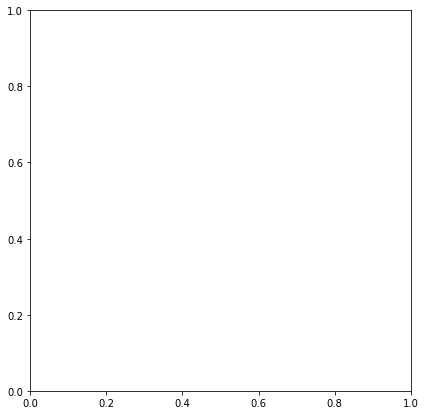

In [109]:
# Combined many FP clips and 1 TP clip into new long clips [old needs to be updated]:

#Generate MANY new long clips--for each TP, select 9 random FP and randomly concatenate together (approximating 60s clip)
dest=TRAIN_AUDIO_ROOT.joinpath('gen_full_tpfp')
if dest.exists()==False:
    os.mkdir(dest)
    #D:\rfcx-species-audio-detection\train\fp_clips\FP_8_00204008d.png
tp=[png for png in TRAIN_AUDIO_ROOT.joinpath('tp_clips').glob('*.png')]
fp=[str(png) for png in TRAIN_AUDIO_ROOT.joinpath('fp_clips').glob('*.png')]
fig, ax = plt.subplots(figsize=(15, 7))
for i,p in enumerate(tp):
    tp_img=rgb2gray(io.imread(p)[:,:,0:3])
    spec=p.parts[-1].split('_')[1]
    rec=p.parts[-1].split('_')[2].split('.')[0]
    use=list(np.random.permutation(24)) # random list of possible FP to include
    use=[s for s in use if s != int(spec)] #exclude FP equal to TP 
    use=use[0:9]
    put_spec=np.random.randint(0,len(use))
    use[put_spec]=int(spec)
    new_fn='TP_%s_%s_FP' % (spec,rec)
    print('Processing %s'% new_fn)
    for j,fp_spec in enumerate(use):
        new_fn=new_fn + '_%d' % fp_spec
        if fp_spec == int(spec):
            #Load TP to this slot
            im=tp_img
        else:
            #Randomly select from available FP of desired species and load im
            fp_rec=df_fp.index[df_fp['species_id']==fp_spec]
            use_fp=fp_rec[np.random.randint(0,len(fp_rec))]
            fpfn=[fn for fn in fp if use_fp in fn][0]
            im=rgb2gray(io.imread(fpfn)[:,:,0:3])
        if j==0:
            a=im
        else:
            a=np.concatenate((a,im),axis=1)
    new_fn = new_fn + '.png'
    img_pnfn=dest.joinpath(new_fn)
    print('\tSaving to %s' % img_pnfn)
    #Plot concatenated spectogram
    plt.imshow(a,cmap='bwr')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(img_pnfn,dpi=250,pad_inches=0,bbox_inches='tight', transparent=True)
    time.sleep(0.1)
    plt.cla()

In [103]:
fp_spec=23
spec=3
use0=list(np.random.permutation(24)) # random list of possible FP to include
use1=[s for s in use0 if s != int(spec)] #exclude FP equal to TP 
use2=use1[0:9]
put_spec=np.random.randint(0,len(use2))
use3=use2
use3[put_spec]=spec
use3

[2, 17, 20, 21, 0, 9, 22, 3, 16]

In [89]:
[s for s in use0 if s != int(spec)]

[11,
 17,
 21,
 22,
 8,
 15,
 2,
 12,
 23,
 16,
 20,
 9,
 4,
 19,
 14,
 13,
 1,
 18,
 6,
 10,
 0,
 5,
 7]

In [ ]:
#Copy tp and fp into species-specific folders:
start_dirs=['tp_clips','fp_clips']
for d in start_dirs:
    src=TRAIN_AUDIO_ROOT.joinpath(d)
    pngs=[png for png in src.glob('*.png')]
    for png in pngs:
        fn=png.parts[-1]
        spec=fn.split('_')[1]
        dest = TRAIN_AUDIO_ROOT.joinpath('spec').joinpath(spec)
        if dest.exists()==False:
            os.mkdir(dest)
        #print('From %s to %s' % (png,dest))
        shutil.copy(str(png),dest)
print('Finished')

In [ ]:
#Move FP clips spectrograms from species-based folders into tp_clips data folder:
for spec in np.unique(df_fp['species_id']):
    path = TRAIN_AUDIO_ROOT.joinpath('%d' % spec)
    pngs=[png for png in path.glob('*.png')]
    for png in pngs:
        fn=png.parts[-1]
        tp=fn.split('_')[0]
        if tp == 'FP':
            print(png)
            shutil.move(str(png),str(TRAIN_AUDIO_ROOT.joinpath('tp_clip')))

In [ ]:
#Copy tp clips into tp_clips:
start_dirs=['tp_clips_and_full',]
for d in start_dirs:
    src=TRAIN_AUDIO_ROOT.joinpath(d)
    pngs=[png for png in src.glob('*.png')]
    for png in pngs:
        fn=png.parts[-1]
        p=fn.split('_')
        if len(p) >= 4:
            is_full=p[3] == 'full.png'
        dest = TRAIN_AUDIO_ROOT.joinpath('tp_clips').joinpath(fn)
        if not is_full:`
            print('From %s to %s' % (png,dest))
            shutil.copy(str(png),dest)
print('Finished')